# Pre-processing and model implementation

In [6]:
# !pip install "nltk==3.4.5"

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from keras.preprocessing.sequence import pad_sequences
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
def cleanText(text):
    tweet_tokenizer = nltk.tokenize.TweetTokenizer() # I have used the TweetTokenizer as tokenizer for each sentence
    stemmer = nltk.stem.cistem.Cistem() # german stemmer.
    stop_words = set(stopwords.words('german')) # the most common words in german
    new_text = [w.lower() for w in tweet_tokenizer.tokenize(text)] # tokenize each sentence and lower all the words
    new_text = [w for w in new_text if bool(re.search(r'\d', w)) == False] #remove any word containg a number
    new_text = [re.sub(r'[^\w\s]','',w) for w in new_text] # remove punctuation
    new_text = [w for w in new_text if w not in stop_words] # remove most common german stop words
    new_text = [stemmer.stem(w) for w in new_text if len(w)>2] # apply stemming on words that have at least 3 letters
    new_text = np.asarray(new_text)
    return new_text

def createVocabulary(df):
  
  vocabulary = {}
  frequency_word = {}
  label_word = 0
  # create the frequency of each word in the entire documents
  for i in range(len(df.index)):
    if i % 5000 == 0 or i == len(df.index)-1:
      print("Creating frequency dictionary from line {} out of {}".format(i, len(df.index)))
    for word in df.iloc[i]['text_cleaned']:
      if word not in frequency_word:
        frequency_word[word] = 0
      else:
        frequency_word[word] += 1

  # select only the words that have a frequency higher than 1 and thus create the vocabulary
  copy_frequency_word = {k:v for k,v in frequency_word.items() if v>1}

  # create the vocabulary after filtering the least used words
  for i in range(len(df.index)):
    if i % 5000 == 0 or i == len(df.index)-1:
      print("Creating vocabulary from line {} out of {}".format(i, len(df.index)))
    for word in df.iloc[i]['text_cleaned']:
      if word in copy_frequency_word and word not in vocabulary:
        vocabulary[word] = label_word
        label_word += 1
  return vocabulary


def getFeatures(df, vocabulary):
  # create the one hot encoded matrix
  features = []
  for i in range(len(df.index)):
    if i % 5000 == 0 or i == len(df.index)-1:
      print("Creating features from line {} out of {}".format(i, len(df.index)))
    feature_row = np.zeros(len(vocabulary))
    for word in df.iloc[i]['text_cleaned']:
      if word in vocabulary:
        feature_row[vocabulary[word]] += 1
    features.append(feature_row)
  
  return features

def processData(df, train, vocabulary=None):
  # call all the functions that are required to pre-process the datasets
  print("\n\n========Cleaning Text=======\n\n")
  df['text_cleaned'] = df['text'].apply(cleanText)
  print(df.head())
  if train == 'yes':
    print("\n\n========Creating Vocabulary=======\n\n")
    vocabulary = createVocabulary(df)
  print("\n\n========Creating Features=======\n\n")
  df = getFeatures(df, vocabulary)

  return df, vocabulary

# I have also tried to use the CountVectorizer and TfidfVectorizer from sklearn, 
# but I eneded up writing the functions manually as they resulted in a better loss. 

# def get_features(data_train, data_validation, data_test):

#   vectorizer = CountVectorizer(
#       strip_accents = 'ascii',
#       min_df = 10,
#       lowercase = False,
#   ) 
#   # create the CountVectorizer instance with the above parameters. The words do not need to be lowered again, keep the words that have a minimum of 10 apparitions among all documents, strip_accents = 'ascii' used for character normalization
#   vectorizer.fit(data_train)  # fit the vectorizer only on the training set
#   features_names = vectorizer.get_feature_names() # get the features name for later examination
#   vocab = vectorizer.vocabulary_ # get the created vocabulary

#   X_train = vectorizer.transform(data_train) # transform the vectorizer for each data set
#   X_validation = vectorizer.transform(data_validation)
#   X_test = vectorizer.transform(data_test)

#   # transform the elements in arrays to be easily manipulated

#   X_train = X_train.toarray() 
#   X_validation = X_validation.toarray()
#   X_test = X_test.toarray()

#   return X_train, X_validation, X_test, features_names, vocab

# I have tried to use embedded words, but they were not successful in obtaining 
# a loss better than the ones provided by creating one hot encoded features. 

# def get_features_embedding(df, vocabulary):
    # max_length = 84 # the longest sentance has 84 words
    # aux_df = []
    # for i in range(len(df.index)):
    #   if i % 5000 == 0 or i == len(df.index)-1:
    #     print("Creating features from line {} out of {}".format(i, len(df.index)))
    #   aux_line = []
    #   for word in df.iloc[i]['text_cleaned']:
    #     if word in vocabulary:
    #       aux_line.append(vocabulary[word])
    #   aux_df.append(aux_line)

    # features = pad_sequences(aux_df, maxlen=max_length, padding='post')


In [10]:
df_train = pd.read_csv(r'/content/drive/MyDrive/PML Project/training.txt', header=None)
df_val = pd.read_csv(r'/content/drive/MyDrive/PML Project/validation.txt', header=None)
df_test = pd.read_csv(r'/content/drive/MyDrive/PML Project/test.txt', header=None)

headers = ["id", "lat", "long", "text"]
df_train.columns = headers
df_val.columns = headers
df_test.columns = ['id', 'text']

In [11]:
print("\n\n==========TRAIN==========\n\n")
X_train, vocabulary = processData(df_train, train='yes')
print("\n\n==========VAL==========\n\n")
X_val,_ = processData(df_val, train='no', vocabulary=vocabulary)
print("\n\n==========TEST==========\n\n")
X_test,_ = processData(df_test, train='no', vocabulary=vocabulary)



==========TRAIN==========




========Cleaning Text=======


       id  ...                                       text_cleaned
0  119165  ...  [seit, vas, kaputt, gang, bring, jahr, ungluck...
1  100377  ...  [haha, isch, amig, richtig, langwilig, bisch, ...
2  109550  ...  [isch, hiltl, dachterrass, amn, samstig, bsuec...
3  111440  ...  [fuhl, weimar, republik, verfassung, bess, aus...
4  116670  ...  [eui, liebsch, lunchidee, mitneh, grill, steak...

[5 rows x 5 columns]


========Creating Vocabulary=======


Creating frequency dictionary from line 0 out of 22583
Creating frequency dictionary from line 5000 out of 22583
Creating frequency dictionary from line 10000 out of 22583
Creating frequency dictionary from line 15000 out of 22583
Creating frequency dictionary from line 20000 out of 22583
Creating frequency dictionary from line 22582 out of 22583
Creating vocabulary from line 0 out of 22583
Creating vocabulary from line 5000 out of 22583
Creating vocabulary from line 10000 ou

In [12]:
# from sklearn.preprocessing import Normalizer
# scaler = Normalizer(norm='l1') 
# scaler.fit(X_train)
# X_train = scaler.transform(X_train) 
# X_val = scaler.transform(X_val)
# X_test = scaler.transform(X_test)

In [13]:
# transform the train, validation and test sets into np arrays
X_train = np.asarray(X_train)
X_val = np.asarray(X_val)
X_test = np.asarray(X_test)
y_train = df_train[['lat', 'long']].to_numpy()
y_val = df_val[['lat', 'long']].to_numpy()

# store the vocabulary size, the number of documents and their length
vocab_size = len(vocabulary)
documents_number = len(X_train)
documents_length = X_train.shape[1]

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(vocab_size)
print(documents_number)
print(documents_length)

(22583, 18759)
(3044, 18759)
(3138, 18759)
18759
22583
18759


In [66]:
import tensorflow as tf

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(256,input_shape = (documents_length,), activation='relu'), # Dense layer with 256 neurons
  tf.keras.layers.Dense(256, activation='relu'), # Dense layer with 256 neurons
  tf.keras.layers.Dense(128, activation='relu'), # Dense layer with 128 neurons
  tf.keras.layers.Dense(64, activation='relu'), # Dense layer with 64 neurons
  tf.keras.layers.Dense(2, activation='relu') # Dense layer with 2 neurons
])

In [ ]:
# The model used for embedded words, that did not perform better than the above one
# model = tf.keras.models.Sequential([
#   tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=64, input_length=documents_length), # embedded layer of input size equal to the length of the vocabulary
#   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)), # trains two LSTM models: the first one as it is (forward) and the second one reversed (backwards)   
#   tf.keras.layers.Dense(2, activation='relu') # output layer
# ])

In [67]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.003) # optimizer + learning rate
model.compile(
    optimizer=optimizer, 
    loss = 'mean_absolute_error', # loss + metric
    metrics = ['mean_squared_error']
              )

In [68]:
import os
checkpoint_dir = './checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir) 
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_dir + '/model.{epoch:05d}.hdf5'
)
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir = os.path.join('logs'),  
    write_graph = True, 
    update_freq = 'epoch'
)

In [69]:
# best score on the validation set was obtained using 50 epochs and a batch_size of 32
history = model.fit(X_train, y_train,
    epochs = 10, batch_size = 32, initial_epoch = 0, verbose=1,
    callbacks=[checkpoint_callback, tensorboard_callback],
    validation_data=(X_val, y_val))

Epoch 1/10
706/706 [==============================] - 24s 33ms/step - loss: 8.2894 - mean_squared_error: 230.6106 - val_loss: 0.7146 - val_mean_squared_error: 0.8833
Epoch 2/10
706/706 [==============================] - 23s 33ms/step - loss: 0.7783 - mean_squared_error: 1.0656 - val_loss: 0.6473 - val_mean_squared_error: 0.7742
Epoch 3/10
706/706 [==============================] - 23s 33ms/step - loss: 0.5772 - mean_squared_error: 0.6444 - val_loss: 0.6409 - val_mean_squared_error: 0.7447
Epoch 4/10
706/706 [==============================] - 23s 33ms/step - loss: 0.4940 - mean_squared_error: 0.4647 - val_loss: 0.6337 - val_mean_squared_error: 0.7662
Epoch 5/10
706/706 [==============================] - 23s 33ms/step - loss: 0.4423 - mean_squared_error: 0.3903 - val_loss: 0.6406 - val_mean_squared_error: 0.7734
Epoch 6/10
706/706 [==============================] - 23s 33ms/step - loss: 0.4119 - mean_squared_error: 0.3346 - val_loss: 0.6425 - val_mean_squared_error: 0.7647
Epoch 7/10
706

In [70]:
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 256)               4802560   
_________________________________________________________________
dense_41 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_42 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_43 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_44 (Dense)             (None, 2)                 130       
Total params: 4,909,634
Trainable params: 4,909,634
Non-trainable params: 0
_________________________________________________________________
None


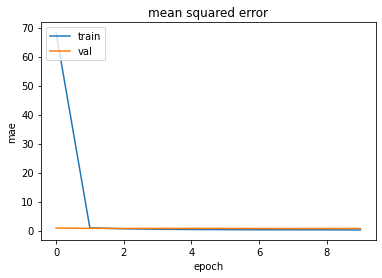

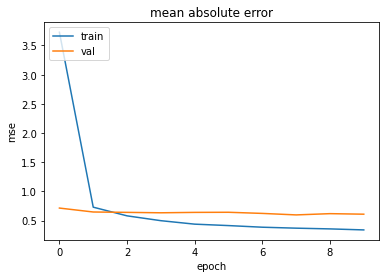

In [71]:
# plot the history of the model to observe it evolution for each epoch
import matplotlib.pyplot as plt

plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])

plt.title('mean squared error')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('mean absolute error')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [72]:
print('the output shape is ', model.output_shape)
print('the input shape is ', model.input_shape)
print('the length of the weights is', len(model.weights))

the output shape is  (None, 2)
the input shape is  (None, 18759)
the length of the weights is 10


In [73]:
test_loss, test_metrics = model.evaluate(X_val, y_val, verbose=1) 
print('test loss mean_squared_error', test_loss)
print('test metrics mean_absolute_error', test_metrics)

96/96 [==============================] - 1s 10ms/step - loss: 0.6097 - mean_squared_error: 0.7194
test loss mean_squared_error 0.6097396016120911
test metrics mean_absolute_error 0.7193634510040283


In [ ]:
# predict the target for the test set and format it according to the given standards
y_test_predicted = model.predict(X_test, verbose = 1)
y_test_predicted = pd.DataFrame(y_test_predicted)
id_test = df_test['id']
y_test_output = pd.concat([y_test_predicted, id_test], axis=1)
y_test_output.columns = ['lat', 'long', 'id']
y_test_output = y_test_output[['id', 'lat', 'long']]
print(y_test_output)
y_test_output.to_csv(r'/content/drive/MyDrive/PML Project/output.txt', index=None)

99/99 [==============================] - 1s 8ms/step
          id        lat       long
0     300121  52.193459  10.687372
1     302441  52.206017   9.862431
2     300266  50.838085   7.994945
3     300911  50.491058  11.165400
4     302681  50.281837   7.967279
...      ...        ...        ...
3133  300151  51.511055  10.115791
3134  300302  51.811520   9.305486
3135  301963  51.238541   9.814710
3136  302180  51.002365   7.924537
3137  301697  51.224594  10.496094

[3138 rows x 3 columns]
